In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

## Load image

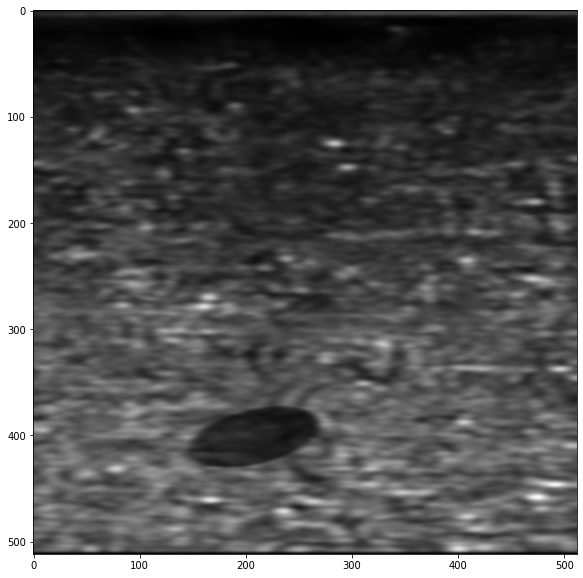

In [2]:
test_dir = "/home/zhenyuli/workspace/us_robot/DataSet/SimRealDatasetTest"
file = test_dir+"/0013/image.png"
img = cv2.imread(file, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255
plt.figure(figsize=(10, 10))
plt.imshow(img,'gray')

In [5]:
import numpy as np
import cv2
import math
from scipy import signal


def Hessian2D(I,Sigma):
    #求输入图像的Hessian矩阵
    #实际上中间包含了高斯滤波，因为二阶导数对噪声非常敏感
    #输入：    
    #   I : 单通道double类型图像
    #   Sigma : 高斯滤波卷积核的尺度  
    #    
    # 输出 : Dxx, Dxy, Dyy: 图像的二阶导数 
    if Sigma<1:
        print("error: Sigma<1")
        return -1
    I=np.array(I,dtype=float)
    Sigma=np.array(Sigma,dtype=float)
    S_round=np.round(3*Sigma)

    [X,Y]= np.mgrid[-S_round:S_round+1,-S_round:S_round+1]

    #构建卷积核：高斯函数的二阶导数
    DGaussxx = 1/(2*math.pi*pow(Sigma,4)) * (X**2/pow(Sigma,2) - 1) * np.exp(-(X**2 + Y**2)/(2*pow(Sigma,2)))
    DGaussxy = 1/(2*math.pi*pow(Sigma,6)) * (X*Y) * np.exp(-(X**2 + Y**2)/(2*pow(Sigma,2)))   
    DGaussyy = 1/(2*math.pi*pow(Sigma,4)) * (Y**2/pow(Sigma,2) - 1) * np.exp(-(X**2 + Y**2)/(2*pow(Sigma,2)))
  
    Dxx = signal.convolve2d(I,DGaussxx,boundary='fill',mode='same',fillvalue=0)
    Dxy = signal.convolve2d(I,DGaussxy,boundary='fill',mode='same',fillvalue=0)
    Dyy = signal.convolve2d(I,DGaussyy,boundary='fill',mode='same',fillvalue=0)

    return Dxx,Dxy,Dyy


def eig2image(Dxx,Dxy,Dyy):
    # This function eig2image calculates the eigen values from the
    # hessian matrix, sorted by abs value. And gives the direction
    # of the ridge (eigenvector smallest eigenvalue) .
    # input:Dxx,Dxy,Dyy图像的二阶导数
    # output:Lambda1,Lambda2,Ix,Iy
    #Compute the eigenvectors of J, v1 and v2
    Dxx=np.array(Dxx,dtype=float)
    Dyy=np.array(Dyy,dtype=float)
    Dxy=np.array(Dxy,dtype=float)
    if (len(Dxx.shape)!=2):
        print("len(Dxx.shape)!=2,Dxx不是二维数组！")
        return 0

    tmp = np.sqrt( (Dxx - Dyy)**2 + 4*Dxy**2)

    v2x = 2*Dxy
    v2y = Dyy - Dxx + tmp

    mag = np.sqrt(v2x**2 + v2y**2)
    i=np.array(mag!=0)

    v2x[i==True] = v2x[i==True]/mag[i==True]
    v2y[i==True] = v2y[i==True]/mag[i==True]

    v1x = -v2y 
    v1y = v2x

    mu1 = 0.5*(Dxx + Dyy + tmp)
    mu2 = 0.5*(Dxx + Dyy - tmp)

    check=abs(mu1)>abs(mu2)
            
    Lambda1=mu1.copy()
    Lambda1[check==True] = mu2[check==True]
    Lambda2=mu2
    Lambda2[check==True] = mu1[check==True]
    
    Ix=v1x
    Ix[check==True] = v2x[check==True]
    Iy=v1y
    Iy[check==True] = v2y[check==True]
    
    return Lambda1,Lambda2,Ix,Iy


def FrangiFilter2D(I):
    I=np.array(I,dtype=float)
    defaultoptions = {'FrangiScaleRange':(5,25), 'FrangiScaleRatio':2, 'FrangiBetaOne':0.5, 'FrangiBetaTwo':15, 'verbose':True,'BlackWhite':True};  
    options=defaultoptions


    sigmas=np.arange(options['FrangiScaleRange'][0],options['FrangiScaleRange'][1],options['FrangiScaleRatio'])
    sigmas.sort()#升序

    beta  = 2*pow(options['FrangiBetaOne'],2)  
    c     = 2*pow(options['FrangiBetaTwo'],2)

    #存储滤波后的图像
    shape=(I.shape[0],I.shape[1],len(sigmas))
    ALLfiltered=np.zeros(shape) 
    ALLangles  =np.zeros(shape) 

    #Frangi filter for all sigmas 
    Rb=0
    S2=0
    for i in range(len(sigmas)):
        #Show progress
        if(options['verbose']):
            print('Current Frangi Filter Sigma: ',sigmas[i])
        
        #Make 2D hessian
        [Dxx,Dxy,Dyy] = Hessian2D(I,sigmas[i])

        #Correct for scale 
        Dxx = pow(sigmas[i],2)*Dxx  
        Dxy = pow(sigmas[i],2)*Dxy  
        Dyy = pow(sigmas[i],2)*Dyy
         
        #Calculate (abs sorted) eigenvalues and vectors  
        [Lambda2,Lambda1,Ix,Iy]=eig2image(Dxx,Dxy,Dyy)  

        #Compute the direction of the minor eigenvector  
        angles = np.arctan2(Ix,Iy)  

        #Compute some similarity measures  
        Lambda1[Lambda1==0] = np.spacing(1)

        Rb = (Lambda2/Lambda1)**2  
        S2 = Lambda1**2 + Lambda2**2
        
        #Compute the output image
        Ifiltered = np.exp(-Rb/beta) * (np.ones(I.shape)-np.exp(-S2/c))
         
        #see pp. 45  
        if(options['BlackWhite']): 
            Ifiltered[Lambda1<0]=0
        else:
            Ifiltered[Lambda1>0]=0
        
        #store the results in 3D matrices  
        ALLfiltered[:,:,i] = Ifiltered 
        ALLangles[:,:,i] = angles

        # Return for every pixel the value of the scale(sigma) with the maximum   
        # output pixel value  
        if len(sigmas) > 1:
            outIm=ALLfiltered.max(2)
        else:
            outIm = (outIm.transpose()).reshape(I.shape)
            
    return outIm

Current Frangi Filter Sigma:  5
Current Frangi Filter Sigma:  7
Current Frangi Filter Sigma:  9
Current Frangi Filter Sigma:  11
Current Frangi Filter Sigma:  13
Current Frangi Filter Sigma:  15
Current Frangi Filter Sigma:  17
Current Frangi Filter Sigma:  19
Current Frangi Filter Sigma:  21
Current Frangi Filter Sigma:  23


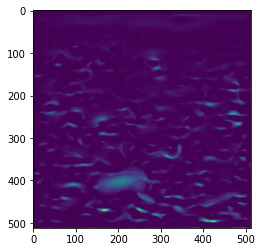

In [6]:

img_filtered = FrangiFilter2D(img)
plt.imshow(img_filtered)

In [60]:
img_norm = np.array(img)
#plt.figure(figsize=(10, 10))
#plt.imshow(img,'gray')
print(np.mean(img_norm))
print(np.var(img_norm))

0.16453034
0.018754633


8.195639e-08
1.0


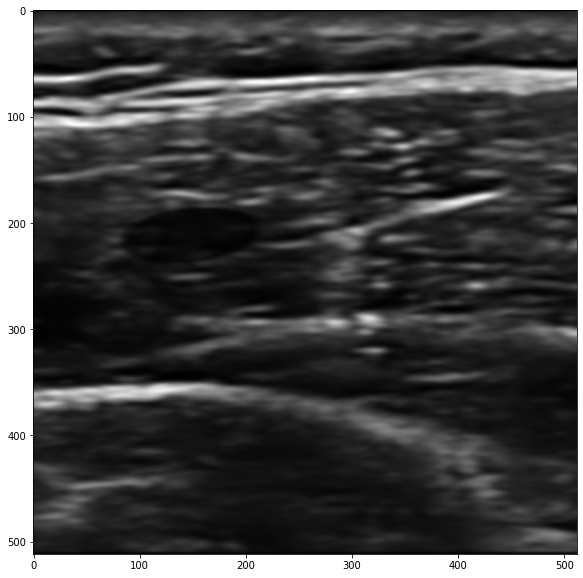

In [61]:

img -= img.mean()
img /= img.std()
img_norm = np.array(img)
print(np.mean(img_norm))
print(np.var(img_norm))
plt.figure(figsize=(10, 10))
plt.imshow(img,'gray')

## image moment

In [19]:

_,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY)
#cv2.imshow('image',img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [4]:
M = cv2.moments(img_bin)

In [5]:
cX = int(M["m10"]/M["m00"])
cY = int(M["m01"]/M["m00"])

ZeroDivisionError: float division by zero

In [6]:
mu20 = M["m20"]/M["m00"]-cX**2
mu02 = M["m02"]/M["m00"]-cY**2
mu11 = M["m11"]/M["m00"]-cX*cY

ZeroDivisionError: float division by zero

In [26]:
covI = np.array([[mu20,mu11],[mu11,mu02]])

In [27]:
w,v = np.linalg.eig(covI)

In [30]:
w

array([3560.29736887,  752.78131497])

In [31]:
v

array([[ 0.99984371,  0.01767902],
       [-0.01767902,  0.99984371]])

In [17]:
v[:,0] = [1,-1]

In [28]:
X = [cX,cX]
Y = [cY,cY]
vct = (np.sqrt(1+12*w)-1)/2*v
#vct =  w*v
U = vct[0]
V = vct[1]

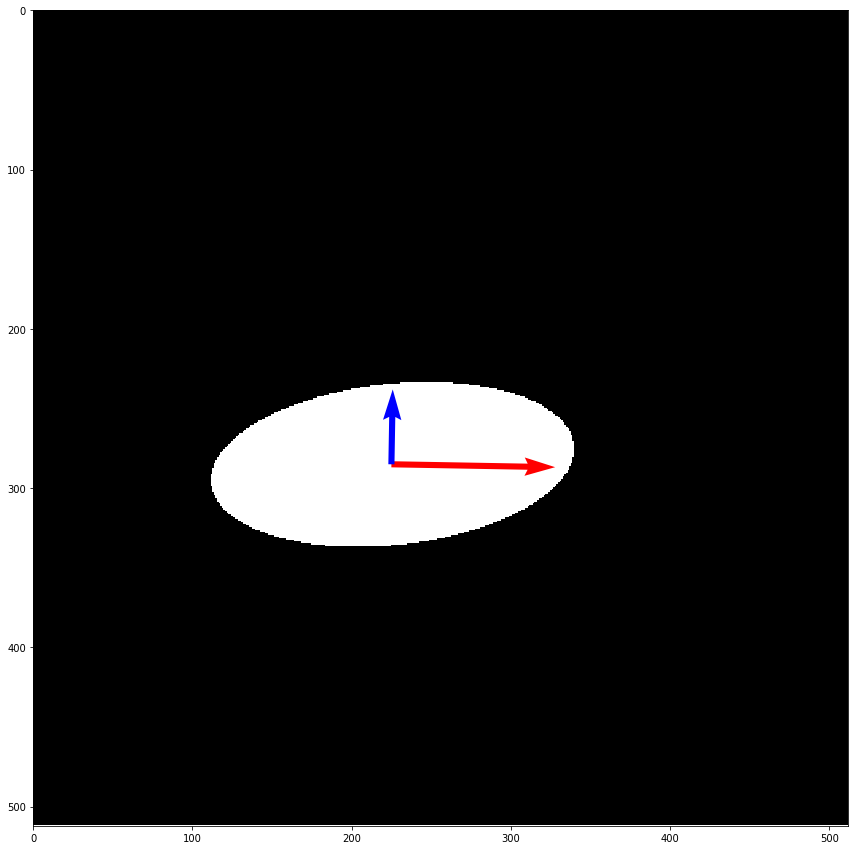

In [29]:
plt.figure(figsize=(15, 15))
ax = plt.gca()
ax.imshow(img_bin,'gray')
ax.quiver(X, Y, U, V, color = ['r','b'], angles='uv', units='x', scale=1, scale_units='x')
ax.set_xlim([0, 512])
ax.set_ylim([0, 512])
ax.invert_yaxis()

In [70]:
(np.sqrt(1+12*w)-1)/2

array([38.57695898, 46.05068073])

In [20]:
laplacian = np.abs(cv2.Laplacian(img_bin,cv2.CV_64F))

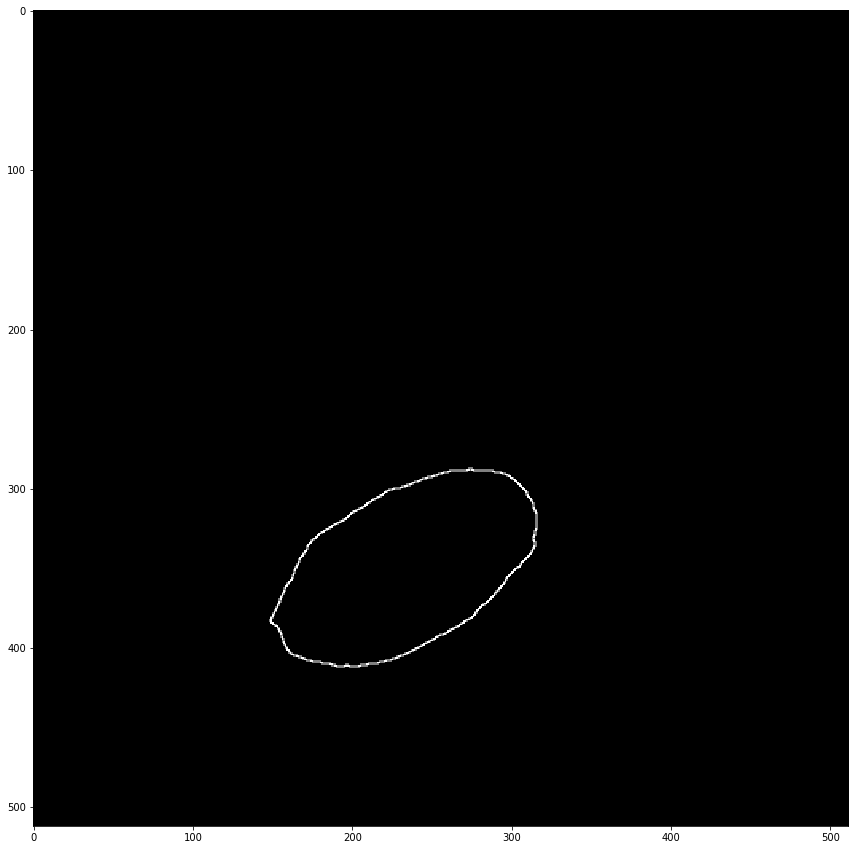

In [101]:
plt.figure(figsize=(15, 15))
plt.imshow(laplacian,cmap = 'gray')

In [22]:
_,edge_bin = cv2.threshold(laplacian,1,255,cv2.THRESH_BINARY)

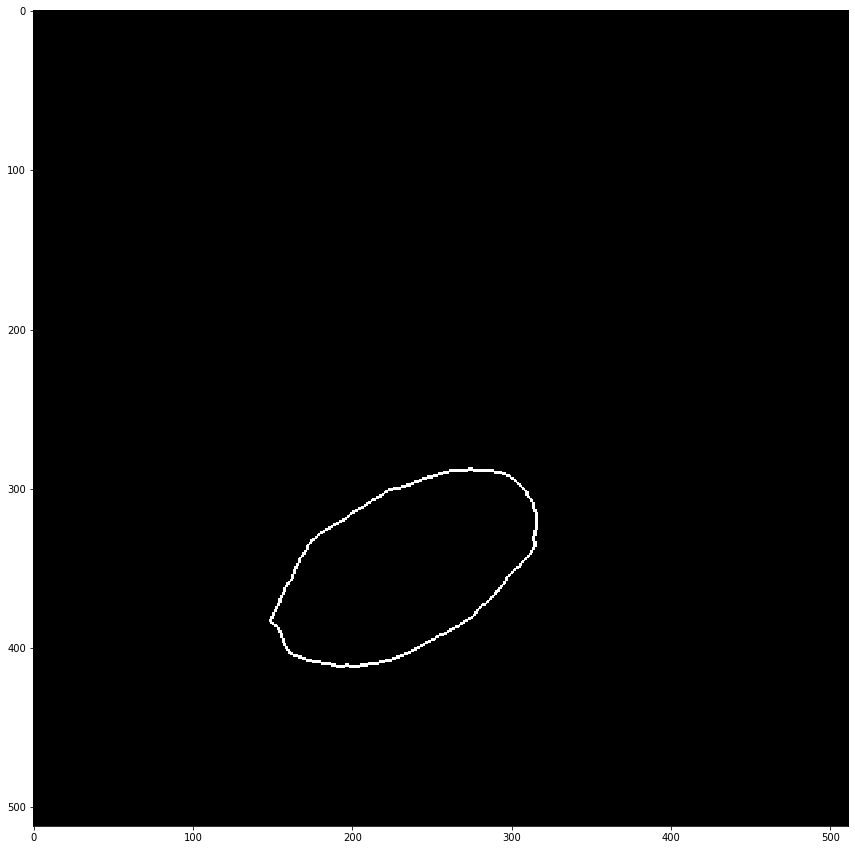

In [24]:
plt.figure(figsize=(15, 15))
plt.imshow(edge_bin,cmap='gray')

In [63]:
x,y = np.nonzero(edge_bin)
A = np.array([x**2,x*y,y**2,x,y,np.ones(len(x))]).transpose()

In [64]:
u,s,vt = np.linalg.svd(A)
a,b,c,d,e,f = list(vt[-1,:]/vt[-1,-1])

In [77]:
yv,xv = np.meshgrid(np.linspace(1,512,512),np.linspace(1,512,512))

In [78]:
A

array([[8.23690e+04, 7.83510e+04, 7.45290e+04, 2.87000e+02, 2.73000e+02,
        1.00000e+00],
       [8.23690e+04, 7.86380e+04, 7.50760e+04, 2.87000e+02, 2.74000e+02,
        1.00000e+00],
       [8.23690e+04, 7.89250e+04, 7.56250e+04, 2.87000e+02, 2.75000e+02,
        1.00000e+00],
       ...,
       [1.69744e+05, 8.32240e+04, 4.08040e+04, 4.12000e+02, 2.02000e+02,
        1.00000e+00],
       [1.69744e+05, 8.36360e+04, 4.12090e+04, 4.12000e+02, 2.03000e+02,
        1.00000e+00],
       [1.69744e+05, 8.40480e+04, 4.16160e+04, 4.12000e+02, 2.04000e+02,
        1.00000e+00]])

In [99]:
img_efit = np.abs(a*xv**2 + b*xv*yv + c*yv**2 + d*xv + e*yv + f)<2e-4

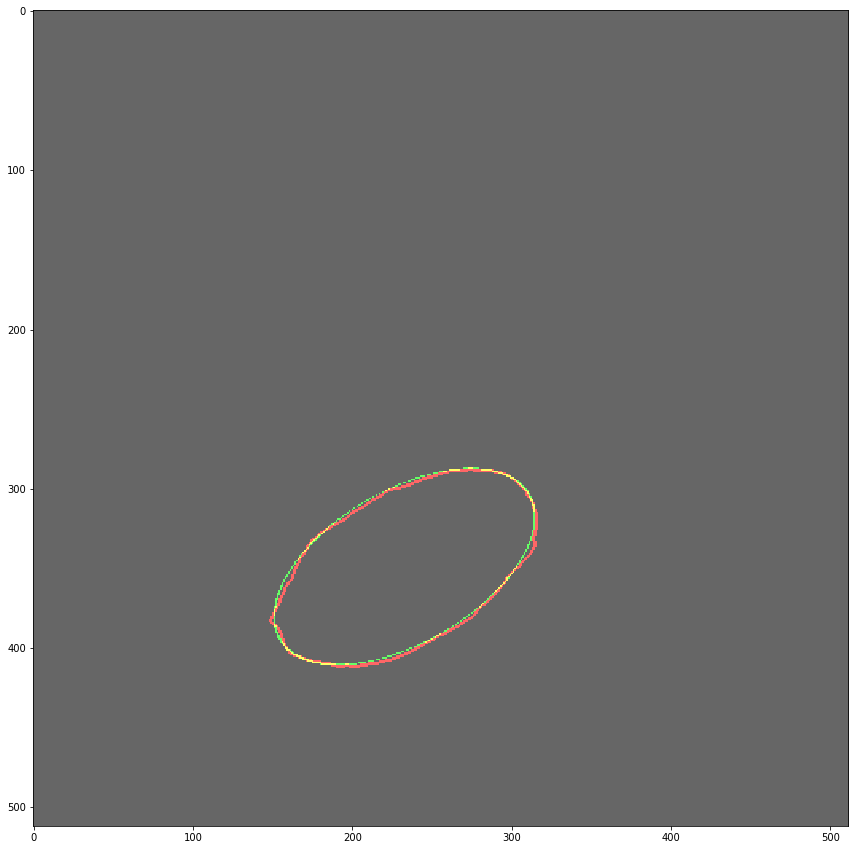

In [100]:
img_comp = np.zeros([512,512,3])
img_comp[:,:,0] = edge_bin/255
img_comp[:,:,1] = img_efit
img_comp[:,:,2]
plt.figure(figsize=(15, 15))
plt.imshow(img_comp,cmap='gray',alpha=0.6)
plt.show()

In [41]:
x = np.array([1,2,3])
y = np.array([3,2,1])
np.array([x**2,x*y,y**2,x,y,np.ones(len(x))]).transpose()

array([[1., 3., 9., 1., 3., 1.],
       [4., 4., 4., 2., 2., 1.],
       [9., 3., 1., 3., 1., 1.]])

In [2]:
cv2.namedWindow('Select Points', cv2.WINDOW_NORMAL)